In [1]:
### Imports
import gzip
from collections import defaultdict
import math
import numpy as np
import string
import random
import string
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import seaborn as sns
import pandas as pd
import os
import time
import itertools

import warnings
warnings.filterwarnings("ignore")

In [2]:
### EVALUATION / METRICS
######################################
def convert_to_np_array(A):
    """
    If A is not already an array, convert it to an array
    """
    if not isinstance(A, np.ndarray): return np.array(A)
    else: return A

def get_MSE(A, B):
    """
    Given list A and list B:
    Return the mean squared error between A and B
    """
    return np.mean((convert_to_np_array(A) - convert_to_np_array(B))**2)

def inner(A, B):
    """
    Return the dot product between list A and list B
    """
    return np.dot(convert_to_np_array(A), convert_to_np_array(B))

def get_SSE(A, B):
    """
    Given list A and list B:
    Return the sum of squared errors between A and B
    """
    return np.sum((convert_to_np_array(A) - convert_to_np_array(B))**2)

def get_SE(A,B):
    """
    Given list A and list B:
    Return the squared error between each element
    """
    return (convert_to_np_array(A) - convert_to_np_array(B))**2

def get_accuracy(A,B):
    """
    Given list A and list B:
    Return the accuracy
    """
    return np.sum(convert_to_np_array(A) == convert_to_np_array(B)) / len(A)

def get_BER(y_actual, y_predicted):
    """
    "Return the balanced error rate between positive (1) and negative(0) instances
    """

    TP, FP, TN, FN = 0, 0, 0, 0
    n_pos, n_neg = 0, 0
    for actual, pred in zip(y_actual, y_predicted):
        if actual==1:
            n_pos += 1
            if actual==pred:
                TP += 1
            else:
                FN += 1
        else:
            n_neg += 1
            if actual==pred:
                TN += 1
            else:
                FP += 1
    FPR = FP / (FP + TN)
    FNR = FN / (FN + TP)
        
    return (1/2) * (FPR + FNR)

def get_errorMetrics_binary(y_actual, y_predicted, beta=1):
    """
    Return a set of error metrics between positive (1) and negative (0) instances
    This is valid for a binary class case
    Return a dictionary containing all calculated values
    """

    output = {}
    TP, FP, TN, FN = 0, 0, 0, 0
    n_pos, n_neg = 0, 0
    for actual, pred in zip(y_actual, y_predicted):
        if actual==1:
            n_pos += 1
            if actual==pred:
                TP += 1
            else:
                FN += 1
        else:
            n_neg += 1
            if actual==pred:
                TN += 1
            else:
                FP += 1
    ###
    TPR, FNR = TP / n_pos, FN / n_pos
    FPR, TNR = FP / n_neg, TN / n_neg
    prec = TP / (TP + FP)
    recall = TP / (TP + FN)
    output["TP"], output["FP"], output["TN"], output["FN"] = TP, FP, TN, FN
    output["TPR"], output["FPR"], output["FNR"], output["TNR"] = TPR, FPR, FNR, TNR
    output["precision"], output["recall"] = prec, recall
    output["BER"] = (1/2) * (FPR + FNR)
    output[f"F{beta}_Score"] = (1 + beta**2) * (prec * recall) / ((beta**2)*prec + recall)
    output["F_Score"] = 2 * (prec * recall) / (prec + recall)

    return output

In [3]:
### SIMILARITY FUNCTIONS
######################################
def jaccard_sim(A,B):
    """
    Return the Jaccard similarity between list A and list B
    """
    if not isinstance(A, set): A = set(A)
    if not isinstance(B, set): B = set(B)
    n_intersect = len(A.intersection(B))
    if n_intersect == 0: return 0
    n_union = len(A.union(B))
    if n_union == 0: return 0

    return n_intersect / n_union

def cosine_sim_binary(A,B, denom_over_all=True):
    """
    Return the cosine similarity between set A and set B (Binary interactions)
    """
    if not isinstance(A, set): A = set(A)
    if not isinstance(B, set): B = set(B)
    n_intersect = len(A.intersection(B))
    # if n_intersect == 0: return 0

    if denom_over_all:
        total_interactions = np.sqrt(len(A) * len(B))
    else:
        total_interactions = n_intersect
    if total_interactions == 0:
        return 0
    return n_intersect / total_interactions

############# Design structures to record shared items
def cosine_sim(x_tuple, y_tuple, denom_over_all):
    """
    Calculate the cosine similarity between lists x and y
    Input are lists of tuples: [(id1, rating), (id2, rating), ...]
    """
    # Get shared items
    x_ids, y_ids = set(), set()
    x_ratings, y_ratings = [], []
    shared_ratings_x, shared_ratings_y = [], []
    shared_tuples_x, shared_tuples_y = [], []
    for tuple in x_tuple:
        x_ids.add(tuple[0])
        x_ratings.append(tuple[1])
    for tuple in y_tuple:
        y_ids.add(tuple[0])
        y_ratings.append(tuple[1])
    shared_ids = x_ids.intersection(y_ids)
    # if len(shared_ids) == 0: return 0

    shared_tuples_x = [tuple for tuple in x_tuple if tuple[0] in shared_ids]
    shared_tuples_x.sort()
    shared_tuples_y = [tuple for tuple in y_tuple if tuple[0] in shared_ids]
    shared_tuples_y.sort()
    shared_ratings_x = [tuple[1] for tuple in shared_tuples_x]
    shared_ratings_y = [tuple[1] for tuple in shared_tuples_y]

    if denom_over_all:
        # Use all items in the denominator
        x_norm = np.sum([xi**2 for xi in x_ratings])
        y_norm = np.sum([yi**2 for yi in y_ratings])
    else:
        # Only use shared items in the denominator
        x_norm = np.sum([xi**2 for xi in shared_ratings_x])
        y_norm = np.sum([yi**2 for yi in shared_ratings_y])
    denom = np.sqrt(x_norm) * np.sqrt(y_norm)

    if denom == 0: return 0
    numer = sum([xi*yi for xi,yi in zip(shared_ratings_x, shared_ratings_y)])

    return numer / denom

def pearson_sim(x_tuple, y_tuple):
    """
    Calculate the pearson similarity between lists x and y
    Input are lists of tuples: [(id1, rating), (id2, rating), ...]
    Unlike Cosine sim, ONLY shared items can be considered
    If id1 or id2 is not in the relevant training data structure, use meanValue as its respective mean
    """
    # Unpack averages
    x_avgs = {tuple[0][0]:tuple[1] for tuple in x_tuple}
    y_avgs = {tuple[0][0]:tuple[1] for tuple in y_tuple}
    # Get shared items
    shared_ratings_x, shared_ratings_y = [], []
    shared_tuples_x, shared_tuples_y = [], []
    x_ids = {tuple[0][0] for tuple in x_tuple}
    y_ids = {tuple[0][0] for tuple in y_tuple}
    shared_ids = x_ids.intersection(y_ids)
    # if len(shared_ids) == 0: return 0

    shared_tuples_x = [tuple[0] for tuple in x_tuple if tuple[0][0] in shared_ids]
    shared_tuples_x.sort()
    shared_tuples_y = [tuple[0] for tuple in y_tuple if tuple[0][0] in shared_ids]
    shared_tuples_y.sort()
    shared_ratings_x = [tuple[1] - x_avgs[tuple[0]] for tuple in shared_tuples_x] ### Pearson --> Subtract the mean from each value
    shared_ratings_y = [tuple[1] - y_avgs[tuple[0]] for tuple in shared_tuples_y]

    # Only use shared items in the denominator
    x_norm = np.sum([xi**2 for xi in shared_ratings_x])
    y_norm = np.sum([yi**2 for yi in shared_ratings_y])
    denom = np.sqrt(x_norm * y_norm)

    if denom == 0: return 0
    numer = sum([xi*yi for xi,yi in zip(shared_ratings_x, shared_ratings_y)])

    return numer / denom


In [4]:
### COLLABORATIVE FILTERING
######################################


def predictValue_bySim_devFromMean(user_id, item_id, sim_func, type, meanValue, value_bounds=None, denom_over_all=None, **kwargs):
    """
    Predict some value (e.g., rating) that the user (user_id) will give an item (item_id) based on
    the input simularity function (sim_func). However, instead of predicting the rating directly,
    predict the deviation from the global mean rating

    # Necessary Data Structures --> These are built using training data ONLY
    itemsPerUser: A dictionary containing the list of items each user interacted with and corresponding values
       ex: itemsPerUser[user1] = [(item1, 2), (item3, 1), (item5, 5), ...]
    usersPerItem: A dictionary containing the list of users that interacted with each item and corresponding values
       ex: usersPerItem[item1] = [(user1, 2), (user4, 2), (user27, 2), ...]
    itemAverages: A dictionary containing the mean value for each item
    userAverages: A dictionary containing the mean value for each user
    #--- value_bounds: The min/max values that can be outputted as typically there's a scale (e.g., 1-5 stars)
    #--- meanValue: The mean of all values in valueDict.values()

    # Gathering similarity weights:
    If type==0:
       # Predict the rating as a weighted sum of ratings that user_id has given to other items #
       For each item (item_id2) that user_id has interacted with (except for item_id):
          Calculate item_id2's similarity to item_id based on shared user interactions
          Track these values as similarity weights
    else:
       # Predict the rating as a weighted sum of ratings that other users have given to item_id #
       For each user (user_id2) that have interacted with item_id (except for user_id):
          Calculate user_id2's similarity to user_id based on shared item interactions
          Track these values as similarity weights
    """
    # Edge case 1: Return global mean value if user_id or item_id are unseen
    if (user_id not in itemsPerUser) or (item_id not in usersPerItem): return meanValue
    # Initialize variables
    if denom_over_all is None: denom_over_all = True
    if value_bounds is None: value_bounds = (-np.inf, np.inf)
    values, similarities = [], []

    if type == "item":
        # Predict the rating as a weighted combination of how other items rated by user_id were
        # rated by similar users
        # if user_id not in userAverages: return meanValue # Skip keys that are not in the dict
        avg_value = userAverages[user_id]
        for user_id2,value in usersPerItem[item_id]:
            if user_id2 == user_id: continue
            # if user_id2 not in userAverages: continue  # Skip keys that are not in the dict
            if sim_func == jaccard_sim:
                simset_user_id = {tuple[0] for tuple in itemsPerUser[user_id] if tuple[0] != item_id}
                simset_user_id2 = {tuple[0] for tuple in itemsPerUser[user_id2] if tuple[0] != item_id}
                similarities.append(sim_func(simset_user_id, simset_user_id2))
            elif sim_func == cosine_sim_binary:
                if denom_over_all is None: denom_over_all = True
                simset_user_id = {tuple[0] for tuple in itemsPerUser[user_id] if tuple[0] != item_id}
                simset_user_id2 = {tuple[0] for tuple in itemsPerUser[user_id2] if tuple[0] != item_id}
                similarities.append(sim_func(simset_user_id, simset_user_id2, denom_over_all))
            elif sim_func == cosine_sim:
                if denom_over_all is None: denom_over_all = True
                simset_user_id = {tuple for tuple in itemsPerUser[user_id] if tuple[0] != item_id}
                simset_user_id2 = {tuple for tuple in itemsPerUser[user_id2] if tuple[0] != item_id}
                similarities.append(sim_func(simset_user_id, simset_user_id2, denom_over_all))
            elif sim_func == pearson_sim:
                simset_user_id = {(tuple, itemAverages[tuple[0]]) for tuple in itemsPerUser[user_id] if tuple[0] != item_id}
                simset_user_id2 = {(tuple, itemAverages[tuple[0]]) for tuple in itemsPerUser[user_id2] if tuple[0] != item_id}
                similarities.append(sim_func(simset_user_id, simset_user_id2))
            else:
                # Sim function not programmed
                print("Invalid sim_func")
                return None
            values.append(value - userAverages[user_id2])
    else:
        # Predict user_id's rating of item_id based on a weighted combination of how other users who
        # rated item_id rated other items
        # if item_id not in itemAverages: return meanValue # Skip keys that are not in the dict
        avg_value = itemAverages[item_id]
        for item_id2,value in itemsPerUser[user_id]:
            if item_id2 == item_id: continue
            # if item_id2 not in itemAverages: continue # Skip keys that are not in the dict
            if sim_func == jaccard_sim:
                simset_item_id = {tuple[0] for tuple in usersPerItem[item_id] if tuple[0] != user_id}
                simset_item_id2 = {tuple[0] for tuple in usersPerItem[item_id2] if tuple[0] != user_id}
                similarities.append(sim_func(simset_item_id, simset_item_id2))
            elif sim_func == cosine_sim_binary:
                if denom_over_all is None: denom_over_all = True
                simset_item_id = {tuple[0] for tuple in usersPerItem[item_id] if tuple[0] != user_id}
                simset_item_id2 = {tuple[0] for tuple in usersPerItem[item_id2] if tuple[0] != user_id}
                similarities.append(sim_func(simset_item_id, simset_item_id2, denom_over_all))
            elif sim_func == cosine_sim:
                if denom_over_all is None: denom_over_all = True
                simset_item_id = {tuple for tuple in usersPerItem[item_id] if tuple[0] != user_id}
                simset_item_id2 = {tuple for tuple in usersPerItem[item_id2] if tuple[0] != user_id}
                similarities.append(sim_func(simset_item_id, simset_item_id2, denom_over_all))
            elif sim_func == pearson_sim:
                simset_item_id = {(tuple, userAverages[tuple[0]]) for tuple in usersPerItem[item_id] if tuple[0] != user_id}
                simset_item_id2 = {(tuple, userAverages[tuple[0]]) for tuple in usersPerItem[item_id2] if tuple[0] != user_id}
                similarities.append(sim_func(simset_item_id, simset_item_id2))
            else:
                # Sim function not programmed
                print("Invalid sim_func")
                return None
            values.append(value - itemAverages[item_id2])
    # Edge case 2: Return global mean value if there are no similar items
    if np.sum(similarities) == 0: return meanValue

    numerator = np.sum([value*sim for value,sim in zip(values, similarities)])
    denominator = np.sum(similarities)
    output = avg_value + (numerator / denominator)
    if output < value_bounds[0]: return value_bounds[0]
    if output > value_bounds[1]: return value_bounds[1]

    return output

In [5]:
### CUSTOM LATENT FACTOR MODEL
######################################
def initialize_params(meanValue, itemsPerUser, usersPerItem, k, init_bounds):
    """
    Return the initialized parameters
    """
    users, items = [key for key in itemsPerUser.keys()], [key for key in usersPerItem.keys()]
    user_count, item_count = len(users), len(items)
    lower, upper = init_bounds
    alpha = meanValue
    user_bias = dict(zip(users, [random.uniform(lower,upper) for i in range(user_count)]))
    item_bias = dict(zip(items, [random.uniform(lower,upper) for i in range(item_count)]))
    user_gamma = dict(zip(users, [np.array([random.uniform(lower,upper) for ki in range(k)]) for i in range(user_count)]))
    item_gamma = dict(zip(items, [np.array([random.uniform(lower,upper) for ki in range(k)]) for i in range(item_count)]))

    return (alpha, user_bias, item_bias, user_gamma, item_gamma, itemsPerUser, usersPerItem)

def get_lfm_defaults(theta):
    """
    Calculate average values/vectors to use as default values for the latent factor predictions
    """
    alpha, user_bias, item_bias, user_gamma, item_gamma, itemsPerUser, usersPerItem = theta
    avg_params = {}
    avg_params["avg_user_bias"] = np.mean(np.array([i for i in user_bias.values()]))
    avg_params["avg_item_bias"] = np.mean(np.array([i for i in item_bias.values()]))
    avg_params["avg_user_gamma"] = np.mean(np.array([values for values in user_gamma.values()]), axis=0)
    avg_params["avg_item_gamma"] = np.mean(np.array([values for values in item_gamma.values()]), axis=0)

    return avg_params

def get_lfm_terms(u_id, item_id, theta, avg_params):
    """
    For an input u_id and item_id, return all bias/gamma terms
    If one is known but the other is not, use an average parameter if available
    """
    alpha, user_bias, item_bias, user_gamma, item_gamma, itemsPerUser, usersPerItem = theta
    u_bias, i_bias, gamma_term = 0, 0, 0
    
    # user bias
    if u_id in user_bias: u_bias = user_bias[u_id]
    # item bias
    if item_id in item_bias: i_bias = item_bias[item_id]
    # user/item gamma
    if (u_id in user_gamma) and (item_id in item_gamma):
        gamma_term = np.dot(user_gamma[u_id], item_gamma[item_id])

    return (u_bias, i_bias, gamma_term)

def predict_latent_factor(u_id, item_id, theta, value_bounds = None, avg_params = None):
    """
    Return the prediction based on u_id and item_id
    If u_id is not in itemsPerUser --> Use the average gamma vector
    Repeat this process for if item_id is not in usersPerItem

    Bound the output by the min and max of the possible values
    (ex: Model shouldn't exceed 5 when the scale is 5)
    """
    alpha, user_bias, item_bias, user_gamma, item_gamma, itemsPerUser, usersPerItem = theta
    if value_bounds is None: value_bounds = (-np.inf, np.inf)
    for i,(gamma_vec) in enumerate(user_gamma.values()):
        if i > 0: break
        k = len(gamma_vec)

    # Reg user/item terms
    u_bias, i_bias, gamma_term = get_lfm_terms(u_id, item_id, theta, avg_params)
    value = alpha + u_bias + i_bias + gamma_term
    # print(value)
    if value < value_bounds[0]: return value_bounds[0]
    if value > value_bounds[1]: return value_bounds[1]

    return value

def get_cost_mse(theta, lambda_bias, lambda_gamma, Xtrain, ytrain, k, value_bounds=None):
    """
    Calculate the cost for the given theta parameters
    Xtrain must be of form [(user, item), (user, item), ...]
    """
    alpha, user_bias, item_bias, user_gamma, item_gamma, itemsPerUser, usersPerItem = theta
    # Predict using the current theta values
    predictions = np.array([predict_latent_factor(tuple[0], tuple[1], theta, value_bounds) for tuple in Xtrain])
    # Get training mse
    mse = get_MSE(predictions, ytrain)
    # Calculate SSE + regularization
    cost = get_SSE(predictions, ytrain)
    cost += lambda_bias * np.sum(np.array([val**2 for val in user_bias.values()]))
    cost += lambda_bias * np.sum(np.array([val**2 for val in item_bias.values()]))
    cost += lambda_gamma * np.sum(np.array([np.dot(gam, gam) for gam in user_gamma.values()]))
    cost += lambda_gamma * np.sum(np.array([np.dot(gam, gam) for gam in item_gamma.values()]))

    return (cost, mse)

def get_batches(x, n):
    limit = len(x)
    for i in range(0, limit, n):
        yield x[i:min(i + n, limit)]

def update_alpha(theta, Xtrain, ytrain):
    alpha, user_bias, item_bias, user_gamma, item_gamma, itemsPerUser, usersPerItem = theta
    alpha_sum = 0
    n_rows = len(ytrain)
    row_sums = np.zeros((n_rows, 4))
    row_sums[:,0] = np.array(ytrain)
    for i,(u_id, item_id) in enumerate(Xtrain):
        row_sums[i,1:] = np.array([-user_bias[u_id], -item_bias[item_id], -np.dot(user_gamma[u_id], item_gamma[item_id])])
    alpha = row_sums.sum() / n_rows
    return alpha, user_bias, item_bias, user_gamma, item_gamma, itemsPerUser, usersPerItem

def update_bias(theta, Xtrain, ytrain, lambda_bias, update_type):
    alpha, user_bias, item_bias, user_gamma, item_gamma, itemsPerUser, usersPerItem = theta
    if update_type == "user":
        dict1, bias1, gamma1 = itemsPerUser, user_bias, user_gamma
        dict2, bias2, gamma2 = usersPerItem, item_bias, item_gamma
    else:
        dict1, bias1, gamma1 = usersPerItem, item_bias, item_gamma
        dict2, bias2, gamma2 = itemsPerUser, user_bias, user_gamma
    for id1 in dict1:
        n_rows = len(dict1[id1])
        row_sums = np.zeros((n_rows, 4))
        row_sums[:,1] = -alpha
        for i,(id2,rating) in enumerate(dict1[id1]):
            row_sums[i,0] = rating
            row_sums[i,2:] = np.array([-bias2[id2], -np.dot(gamma1[id1], gamma2[id2])])
        bias1[id1] = row_sums.sum() / (n_rows + lambda_bias)
    if update_type == "user": 
        user_bias = bias1.copy()
    else: 
        item_bias = bias1.copy()
    return alpha, user_bias, item_bias, user_gamma, item_gamma, itemsPerUser, usersPerItem

def update_bias_and_gamma(theta, Xtrain, ytrain, lambda_bias, lambda_gamma, update_type, k):
    alpha, user_bias, item_bias, user_gamma, item_gamma, itemsPerUser, usersPerItem = theta
    if update_type == "user":
        dict1, bias1, gamma1 = itemsPerUser, user_bias.copy(), user_gamma.copy()
        dict2, bias2, gamma2 = usersPerItem, item_bias.copy(), item_gamma.copy()
    else:
        dict1, bias1, gamma1 = usersPerItem, item_bias.copy(), item_gamma.copy()
        dict2, bias2, gamma2 = itemsPerUser, user_bias.copy(), user_gamma.copy()
    for id1 in dict1:
        n_rows = len(dict1[id1])
        row_sums = np.zeros((n_rows, 4))
        row_sums[:,1] = -alpha
        #
        row_sums2 = np.zeros((n_rows, 4))
        row_sums2[:,1] = -alpha
        gamma2s = np.zeros((n_rows, k))
        gamma2s_sqrd = np.zeros((n_rows, k))
        for i,(id2,rating) in enumerate(dict1[id1]):
            row_sums[i,0] = rating
            row_sums[i,2:] = np.array([-bias2[id2], -np.dot(gamma1[id1], gamma2[id2])])
            row_sums2[i,0] = rating
            row_sums2[i,3] = -bias2[id2]
            gamma2s[i,:] = gamma2[id2]
            gamma2s_sqrd[i,:] = (gamma2[id2]**2)
        bias1[id1] = row_sums.sum() / (n_rows + lambda_bias)
        # Update gamma1
        row_sums2[:,2] = np.full(n_rows, -bias1[id1])
        sum_term = np.repeat(row_sums2.sum(axis=1)[:, np.newaxis], k, axis=1)
        gamma1[id1] = (sum_term * gamma2s).sum(axis=0) / (gamma2s_sqrd.sum(axis=0) + lambda_gamma)
    if update_type == "user": 
        user_bias = bias1.copy()
        user_gamma = gamma1.copy()
    else: 
        item_bias = bias1.copy()
        item_gamma = gamma1.copy()
    return alpha, user_bias, item_bias, user_gamma, item_gamma, itemsPerUser, usersPerItem

def update_params(theta, lambda_bias, lambda_gamma, Xtrain, ytrain):
    """
    Update parameters based on how well they predict in their CURRENT states
    Coordinate descent instead of gradient descent for faster convergence
    ###
    Latent factor model
         Fix user_gamma --> iterate and update alpha, user_bias, item_gamma
         Fix item_gamma --> iterate and update alpha, user_bias, user_gamma
    Fix user_gamma... Fix item_gamma...
    Repeat the above until model have converged
    """
    alpha, user_bias, item_bias, user_gamma, item_gamma, itemsPerUser, usersPerItem = theta

    # Calculate the new alpha
    t0 = time.time()
    theta = update_alpha(theta, Xtrain, ytrain)
    # print(f"   Alpha Complete --> Time elapsed: {time.time() - t0}")
    # user bias and gamma
    t0 = time.time()
    theta = update_bias_and_gamma(theta, Xtrain, ytrain, lambda_bias, lambda_gamma, "user", k)
    # print(f"   User Bias and Gamma Complete --> Time elapsed: {time.time() - t0}")
    # item bias and gamma
    t0 = time.time()
    theta = update_bias_and_gamma(theta, Xtrain, ytrain, lambda_bias, lambda_gamma, "item", k)
    # print(f"   Item Bias and Gamma Complete --> Time elapsed: {time.time() - t0}")
        
        # if cycle % 2:
        #     # item bias
        #     t0 = time.time()
        #     theta = update_bias(theta, Xtrain, ytrain, lambda_bias, "item")
        #     print(f"   Item Biases Complete --> Time elapsed: {time.time() - t0}")
        #     # user bias and gamma
        #     t0 = time.time()
        #     theta = update_bias_and_gamma(theta, Xtrain, ytrain, lambda_bias, lambda_gamma, "user", k)
        #     print(f"   User Bias and Gamma Complete --> Time elapsed: {time.time() - t0}")
        # else:
        #     # user bias
        #     t0 = time.time()
        #     theta = update_bias(theta, Xtrain, ytrain, lambda_bias, "user")
        #     print(f"   User Bias Complete --> Time elapsed: {time.time() - t0}")
        #     # item bias and gamma
        #     t0 = time.time()
        #     theta = update_bias_and_gamma(theta, Xtrain, ytrain, lambda_bias, lambda_gamma, "item", k)
        #     print(f"   Item Bias and Gamma Complete --> Time elapsed: {time.time() - t0}")

    return theta

def fit_parameters(Xtrain, ytrain, theta, ep=0.0005, iter_limit=200, quiet=True, value_bounds=(-np.inf, np.inf), mini_batch=False, n_mini_batch=None, **kwargs):
    """
    Fit the parameters until convergence (when difference in cost is less than ep)
    Arguments packed into **kwargs:
    lambda_bias --> Regularization parameter for the user/item biases
    lambda_gamma --> Regularization parameter for the user/item gamma matrix
    k --> Number of latent parameters to use per user/item vector
    ep --> The threshold for early stopping between mse checks
    iter_limit --> The maximum number of iterations allowed
    value_bounds --> The expected range of values expected to be outputted by the model
    check_every --> Calculate the cost/mse whenever iter_count is perfectly divisible by check_every (ex: check_every=10 means check every 10 iterations)
    """
    last_mse, last_cost = np.inf, np.inf
    best_params = [theta, last_mse, last_cost]
    epoch_count = 0
    if mini_batch:
        if n_mini_batch is None: n_mini_batch = 5
        batch_size = math.ceil(len(ytrain) / n_mini_batch)

    if not quiet:
        print("Fitting parameters...\n-----")
    while True:
        epoch_count += 1
        ### Update theta
        t_theta = time.time()
        if mini_batch:
            X_y = list(zip(Xtrain, ytrain))
            random.shuffle(X_y)
            Xtrain, ytrain = zip(*X_y)
            for X_batch, y_batch in zip(get_batches(Xtrain, batch_size), get_batches(ytrain, batch_size)):
                theta = update_params(theta, lambda_bias, lambda_gamma, X_batch, y_batch)
        else:
            theta = update_params(theta, lambda_bias, lambda_gamma, Xtrain, ytrain)

        ### Compute cost and output results as needed
        cost, mse = get_cost_mse(theta, lambda_bias, lambda_gamma, Xtrain, ytrain, k)
        if not quiet:
            print(f"-----\nEpoch {epoch_count}: Cost = {cost}, Train MSE = {mse}, Time Elapsed: {time.time() - t_theta}\n-----")

        ### Save current params as best_params if the mse is less than the last mse
        if mse < best_params[1]:
            best_params = [theta, mse, cost]
        ### Check if cost is too high - sometimes the algorithm diverges
        if mse > 5000:
            theta, mse, cost = best_params
            print(f"Training MSE too high: Best Train MSE = {best_params[1]}")
            break
        ### Early stop if the ep condition is met
        if (abs(last_mse - mse) > ep):
            last_mse, last_cost = mse, cost
        else:
            print(f"Convergence after {epoch_count} epochs: Cost = {cost}, Train MSE = {mse}")
            break
        ### If the iteration limit is reached, stop and return the best parameters
        if epoch_count > iter_limit:
            theta, mse, cost = best_params
            print(f"Iteration limit reached after {epoch_count} epochs: Best Train MSE = {best_params[1]}")
            break

    return (theta, cost, mse)


In [6]:
### Popularity-based Baseline
######################################

# Rank the items in the dataset based on popularity --> If the item is popular, predict 1, else 0

def get_item_popularities(df, col):
    # Define popularity: The items which have the highest playtime per person ratios weighted by number of plays
    item_playCounts = df.groupby("item_id").agg("sum")[col]
    item_playCountsBinary = df.groupby("item_id").agg("sum")["playtime_binary"]
    item_userCounts = df.groupby("item_id").count()["user_id"]

    item_playsPerUser = (item_playCountsBinary / item_userCounts).sort_values(ascending=True)
    # item_playsPerUser = (item_playCounts).sort_values(ascending=True)

    return pd.DataFrame({"pop_values":item_playsPerUser, "pop_sums":item_playsPerUser.cumsum()})

def get_most_popular_items(df, cutoff):
    pop_cutoff = df["pop_values"].max() * cutoff

    return list(df[df["pop_values"] > pop_cutoff].index)

def predict_by_popularity(X, pop_items):
    if isinstance(X, tuple):
        if X[1] in pop_items: return 1
        else: return 0
    else:
        output = pd.Series([0 for i in range(len(X))])
        output[X["item_id"].isin(pop_items)] = 1
        return output

#####

In [7]:
### OTHER HELPFUL FUNCTIONS
######################################
def get_rec_structs(train_data):
    """
    Extract stats used for creating the classifier features
    Input is (user_id, item_id, value), ...
    Typically value is rating, but can be other things (e.g., hours played)

    itemsPerUser: Records each item in the training set that each user interacted with (along with the corresponding value)
    usersPerItem: Records each user in the training set that each item interacted with (along with the corresponding value)
    valueDict: Records the value for each (user, item) tuple
    userAverages: Gives the average value for each user
    itemAverages: Gives the average value for each item

    """
    ### Record which items each user interacted with and which users interacted with which item
    itemsPerUser = defaultdict(list)
    usersPerItem = defaultdict(list)
    userItemDict, itemUserDict = {}, {}
    for u,b,v in train_data:
        itemsPerUser[u].append((b,v))
        usersPerItem[b].append((u,v))
        userItemDict[(u,b)] = v
        itemUserDict[(b,u)] = v

    ### Calculate user and item average ratings
    userAverages = {}
    itemAverages = {}
    for u,tuples in itemsPerUser.items():
        values = [value for item,value in tuples]
        # values = [value for item,value in tuples if value != 0]
        # if len(values) == 0: continue
        userAverages[u] = sum(values) / len(values)
    for i,tuples in usersPerItem.items():
        values = [value for user,value in tuples]
        # values = [value for user,value in tuples if value != 0]
        # if len(values) == 0: continue
        itemAverages[i] = sum(values) / len(values)

    rec_structs = {"itemsPerUser":itemsPerUser,
                  "usersPerItem":usersPerItem,
                  "userItemDict":userItemDict,
                  "itemUserDict":itemUserDict,
                  "userAverages":userAverages,
                  "itemAverages":itemAverages,}

    return rec_structs


def unpack_rec_structs(rec_structs):
    """
    Take the input recommender_structs and return the itemized contents
    Not used in this assignment
    """
    itemsPerUser = rec_structs["itemsPerUser"]
    usersPerItem = rec_structs["usersPerItem"]
    userItemDict = rec_structs["userItemDict"]
    itemUserDict = rec_structs["itemUserDict"]
    userAverages = rec_structs["userAverages"]
    itemAverages = rec_structs["itemAverages"]

    return (itemsPerUser, usersPerItem, userItemDict, itemUserDict, userAverages, itemAverages)

def pd_get_rec_structs(df, user_col, item_col, val_col, user_limit=None, item_limit=None, only_nonzero=None):
    """
    Like get_rec_structs(), but is customized for the pandas library
    Extract stats used for creating the classifier features
    Input is df which has at least a user_col, item_col, val_col, ...
    Typically value is rating, but can be other things (e.g., hours played)

    itemsPerUser: Records each item in the training set that each user interacted with (along with the corresponding value)
    usersPerItem: Records each user in the training set that each item interacted with (along with the corresponding value)
    valueDict: Records the value for each (user, item) tuple
    userAverages: Gives the average value for each user
    itemAverages: Gives the average value for each item

    user/item limit allows for estimating with less data to save time
    only_nonzero: Only track users/items that have non-zero values
    """
    if only_nonzero is None: only_nonzero = False
    df2 = df.copy()
    df2["itemsPerUser"] = list(zip(df2[item_col], df2[val_col]))
    df2["usersPerItem"] = list(zip(df2[user_col], df2[val_col]))
    df2["user_item"] = list(zip(df2[user_col], df2[item_col]))
    #
    if user_limit is None: user_limit = len(df)
    if item_limit is None: item_limit = len(df)
    # Limit data to only_nonzero if necessary
    if only_nonzero: df2 = df2[df2[val_col] > 0]
    itemsPerUser = df2.groupby(user_col)["itemsPerUser"].apply(lambda x: list(x)[:item_limit]).to_dict()
    usersPerItem = df2.groupby(item_col)["usersPerItem"].apply(lambda x: list(x)[:user_limit]).to_dict()

    valueDict = df2[["user_item", val_col]].set_index("user_item", drop=True).to_dict()[val_col]
    userAverages = df2.groupby(user_col)[val_col].mean().to_dict()
    itemAverages = df2.groupby(item_col)[val_col].mean().to_dict()
    meanValue = np.mean([val for val in valueDict.values()])

    return itemsPerUser, usersPerItem, valueDict, userAverages, itemAverages, meanValue

### Functions to read files (From homework stubs)
def readGz(path):
    output = []
    for l in gzip.open(path, mode = 'rt', encoding = "utf-8"):
        output.append(eval(l))
    return output

def readCSV(path):
    f = gzip.open(path, 'rt')
    f.readline()
    for l in f:
        u,b,r = l.strip().split(',')
        r = int(r)
        yield u,b,r

def plot_lfm_results(results, max_results=None):
    results_to_pd = []
    for result in results:
        results_to_pd.append({"MSE":result[0], "k":result[1][0], \
                              "lambda_bias":result[1][1], "lambda_gamma":result[1][2]})
    
    results_df = pd.DataFrame(results_to_pd)
    results_df
    
    n_results = len(results_df)
    n_k = len(results_df.k.unique())
    n_lambda_gammas = len(results_df.lambda_gamma.unique())
    n_lambda_biases = len(results_df.lambda_bias.unique())
    cmap = cm.viridis
    norm = colors.Normalize()
    if max_results is None:
        max_results = np.inf
    
    if n_k == 1: n_subplot_rows = 2
    else: n_subplot_rows = n_k
    fig,axes = plt.subplots(n_subplot_rows, 1, figsize=(10, 5*n_subplot_rows))
    ax1_count = 0
    
    for i,(k,ax) in enumerate(zip(results_df.k.unique(), axes.flatten())):
        plot_data = results_df[results_df["k"] == k]
        plot_data[plot_data["MSE"] > max_results] = max_results
        mses, lambda_biases, lambda_gammas = plot_data.MSE, plot_data.lambda_bias, plot_data.lambda_gamma
        best_mse = mses.min()
        plot_valid_mses = np.flip(mses.to_numpy().reshape((n_lambda_gammas, n_lambda_biases)), axis=0)
        extent = [np.min(lambda_biases), np.max(lambda_biases), np.min(lambda_gammas), np.max(lambda_gammas)]
        plot0 = ax.imshow(plot_valid_mses.T, extent=extent)
    
        ax.set(title=f"MSE at k = {k}\nBest MSE = {best_mse}", xlabel="lambda_bias", ylabel="lambda_gamma", \
               xlim=[np.min(lambda_biases), np.max(lambda_biases)], ylim=[np.min(lambda_gammas), np.max(lambda_gammas)])
        plt.colorbar(plot0, cmap=cmap, norm=norm, ax=ax)
    
    plt.tight_layout()
    plt.show()

In [8]:
%%time
### Load review data
seed = 100

minmax_scalers = pd.read_csv("data/minmax_scalers.csv")
# test_df_results = pd.read_csv("data/test_df_results.csv")

# Train/valid/train2/test
train_filepath = "data/train_df.csv"
valid_filepath = "data/valid_df.csv"
train2_filepath = "data/train_df2.csv"
test_filepath = "data/test_df.csv"
train_df = pd.read_csv(train_filepath)
valid_df = pd.read_csv(valid_filepath)
train_df2 = pd.read_csv(train2_filepath)
test_df = pd.read_csv(test_filepath)

# Further split the data into X/y pairs for convenience
class_col = "playtime_log" # This what we want to predict
X_train, y_train = train_df[["user_id", "item_id"]], train_df[class_col]
X_valid, y_valid = valid_df[["user_id", "item_id"]], valid_df[class_col]
X_test, y_test = test_df[["user_id", "item_id"]], test_df[class_col]
X_train2, y_train2 = train_df2[["user_id", "item_id"]], train_df2[class_col]

X_train2

CPU times: total: 516 ms
Wall time: 526 ms


,user_id,item_id
0,u2194,9350
1,u7381,219890
2,u8653,238210
3,u7474,2430
4,u4426,11200
...,...,...
676905,u6686,110800
676906,u740,49600
676907,u11882,409720
676908,u3544,221380


### LATENT FACTOR MODEL

In [9]:
t0 = time.time()

In [10]:
##### itemsPerUser
itemsPerUser, usersPerItem, valueDict, userAverages, itemAverages, meanValue = pd_get_rec_structs(train_df, "user_id", "item_id", class_col)

print(len(itemsPerUser))
print(len(usersPerItem))
print(len(valueDict))
print(len(userAverages))
print(len(itemAverages))
print(meanValue)

14540
9151
541528
14540
9151
3.3104654998952894


In [11]:
%%time
### Initialize parameters for GRIDSEARCH
k_values = [1]
lambda_biases = [i for i in np.linspace(0,6,10)]
lambda_gammas = [i for i in np.linspace(0,6,10)]
n_combos = len(k_values) * len(lambda_biases) * len(lambda_gammas)
#
ep = 0.005
iter_limit = 300
output_bounds = (0, np.inf)
combos = itertools.product(*(k_values, lambda_biases, lambda_gammas))

times = []
results = []
for i,combo in enumerate(combos):
    t_start = time.time()
    # print(f"#-----\nIteration {i + 1}/{n_combos}")
    k, lambda_bias, lambda_gamma = combo

    params = {
             "lambda_bias": lambda_bias, "lambda_gamma": lambda_gamma,
             "k": k, "ep": ep, "iter_limit": iter_limit, "output_bounds": output_bounds
             }
    
    init_bounds = (-.1,.1)
    theta = initialize_params(meanValue, itemsPerUser, usersPerItem, k, init_bounds)
    
    ### Fit the model to the training data
    theta, cost, mse = fit_parameters(X_train.values.tolist(), y_train, theta, quiet=True, **params)
    avg_params = get_lfm_defaults(theta)
    
    ### Predict using the learned parameters
    predictions = [predict_latent_factor(u_id, item_id, theta, output_bounds, avg_params) for (u_id,item_id) in X_valid.values.tolist()]
    validMSE = get_MSE(predictions, y_valid)
    t_elapsed = time.time() - t_start
    
    # print(f"Valid MSE = {validMSE}, Combo Parameters = {combo}")
    print(f"#-----\nIteration {i + 1}/{n_combos}: Valid MSE = {validMSE}, Combo Parameters = {combo}")
    print(f"Time elapsed = {t_elapsed // 60} min and {t_elapsed % 60}s ({t_elapsed}s)")

    times.append((t_elapsed, combo))
    results.append((validMSE, combo))

Convergence after 13 epochs: Cost = 2196174.599932365, Train MSE = 4.0555143961759414
#-----
Iteration 1/100: Valid MSE = 5.421893025540095, Combo Parameters = (1, 0.0, 0.0)
Time elapsed = 1.0 min and 15.771487474441528s (75.77148747444153s)
Convergence after 11 epochs: Cost = 2196484.7140804166, Train MSE = 4.0264259162504175
#-----
Iteration 2/100: Valid MSE = 4.147657075939483, Combo Parameters = (1, 0.0, 0.6666666666666666)
Time elapsed = 1.0 min and 10.150934934616089s (70.15093493461609s)
Convergence after 10 epochs: Cost = 2221841.200034994, Train MSE = 4.064449609454593
#-----
Iteration 3/100: Valid MSE = 4.181269820582037, Combo Parameters = (1, 0.0, 1.3333333333333333)
Time elapsed = 1.0 min and 6.528456211090088s (66.52845621109009s)
Convergence after 9 epochs: Cost = 2227933.4395176754, Train MSE = 4.065769581667649
#-----
Iteration 4/100: Valid MSE = 4.181250347599356, Combo Parameters = (1, 0.0, 2.0)
Time elapsed = 0.0 min and 58.096423387527466s (58.096423387527466s)
Con

In [12]:
results

[(5.421893025540095, (1, 0.0, 0.0)),
 (4.147657075939483, (1, 0.0, 0.6666666666666666)),
 (4.181269820582037, (1, 0.0, 1.3333333333333333)),
 (4.181250347599356, (1, 0.0, 2.0)),
 (4.159416835482152, (1, 0.0, 2.6666666666666665)),
 (4.16146237739849, (1, 0.0, 3.333333333333333)),
 (4.171693298441471, (1, 0.0, 4.0)),
 (4.192938179754505, (1, 0.0, 4.666666666666666)),
 (4.199450895728554, (1, 0.0, 5.333333333333333)),
 (4.1717429834690885, (1, 0.0, 6.0)),
 (5.256814350883769, (1, 0.6666666666666666, 0.0)),
 (4.159099081128472, (1, 0.6666666666666666, 0.6666666666666666)),
 (4.164060133693579, (1, 0.6666666666666666, 1.3333333333333333)),
 (4.156477008075843, (1, 0.6666666666666666, 2.0)),
 (4.157950737373503, (1, 0.6666666666666666, 2.6666666666666665)),
 (4.1607401300464035, (1, 0.6666666666666666, 3.333333333333333)),
 (4.187252429709311, (1, 0.6666666666666666, 4.0)),
 (4.191764693522772, (1, 0.6666666666666666, 4.666666666666666)),
 (4.195936640765638, (1, 0.6666666666666666, 5.333333

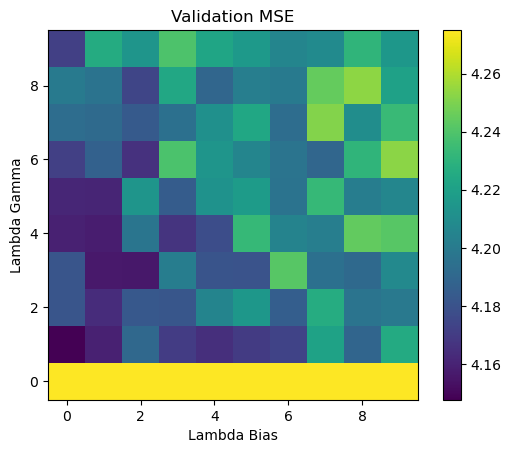

In [35]:
max_mse = 4.275
###
mse, lambda_b, lambda_g = [], [], []
for result in results:
    mse.append(result[0])
    lambda_b.append(result[1][1])
    lambda_g.append(result[1][2])

mse = np.array(mse).reshape((10,10)).T
mse[np.where(mse > max_mse)] = max_mse
# print(mse.shape)

plt.imshow(mse, origin="lower")
plt.colorbar()
plt.title("Validation MSE")
plt.xlabel("Lambda Bias")
plt.ylabel("Lambda Gamma")
plt.savefig("images/models_LFM")

plt.show()

In [14]:
# plot_lfm_results(results, max_results = 4.28)

In [15]:
# # GET THE BEST RESULTS
results2 = results.copy()
results2.sort()

results2[:5]

[(4.147657075939483, (1, 0.0, 0.6666666666666666)),
 (4.155639580505811, (1, 1.3333333333333333, 2.0)),
 (4.156477008075843, (1, 0.6666666666666666, 2.0)),
 (4.157950737373503, (1, 0.6666666666666666, 2.6666666666666665)),
 (4.159099081128472, (1, 0.6666666666666666, 0.6666666666666666))]

In [16]:
##### itemsPerUser
itemsPerUser, usersPerItem, valueDict, userAverages, itemAverages, meanValue = pd_get_rec_structs(train_df2, "user_id", "item_id", class_col)

print(len(itemsPerUser))
print(len(usersPerItem))
print(len(valueDict))
print(len(userAverages))
print(len(itemAverages))
print(meanValue)

14551
9214
568502
14551
9214
3.309611240257363


In [17]:
%%time
### Initialize parameters for 
k = results2[0][1][0]
lambda_bias = results2[0][1][1]
lambda_gamma = results2[0][1][2]
# k = 1
# lambda_bias = 1
# lambda_gamma = 1

ep = 0.0005
iter_limit = 300
output_bounds = (0, np.inf)
params = {
         "lambda_bias": lambda_bias, "lambda_gamma": lambda_gamma,
         "k": k, "ep": ep, "iter_limit": iter_limit, "output_bounds": output_bounds
         }

init_bounds = (-1, 1)
theta = initialize_params(meanValue, itemsPerUser, usersPerItem, k, init_bounds)

### Fit the model to the training data
t_start = time.time()
theta, cost, mse = fit_parameters(X_train2.values.tolist(), y_train2, theta, mini_batch=False, n_mini_batch=10, quiet=False, **params)
# avg_params = get_lfm_defaults(theta)

print(f"Training Time elapsed = {time.time() - t_start}\n")
t_start = time.time()

### Predict using the learned parameters
predictions1 = [predict_latent_factor(u_id, item_id, theta, output_bounds) for (u_id,item_id) in X_test.values.tolist()]
testMSE = get_MSE(predictions1, y_test)
t_elapsed = time.time() - t_start

print(f"Test MSE = {testMSE}")
print(f"Time elapsed = {t_elapsed // 60} min and {t_elapsed % 60}s ({t_elapsed}s)")

Fitting parameters...
-----
-----
Epoch 1: Cost = 3195396.6524597583, Train MSE = 4.694866639090616, Time Elapsed: 6.426999092102051
-----
-----
Epoch 2: Cost = 2921109.1552001373, Train MSE = 4.286856317997196, Time Elapsed: 6.616000652313232
-----
-----
Epoch 3: Cost = 2882512.302009994, Train MSE = 4.229157003845997, Time Elapsed: 6.605000257492065
-----
-----
Epoch 4: Cost = 2865821.5531811933, Train MSE = 4.204502423379931, Time Elapsed: 6.792001247406006
-----
-----
Epoch 5: Cost = 2855023.644466845, Train MSE = 4.188766421420933, Time Elapsed: 6.466999530792236
-----
-----
Epoch 6: Cost = 2846754.561366366, Train MSE = 4.176901137288, Time Elapsed: 6.418367624282837
-----
-----
Epoch 7: Cost = 2839226.6302478854, Train MSE = 4.166224261041793, Time Elapsed: 6.067369222640991
-----
-----
Epoch 8: Cost = 2830831.0370678543, Train MSE = 4.154328743787367, Time Elapsed: 6.375384330749512
-----
-----
Epoch 9: Cost = 2820086.4376153303, Train MSE = 4.138985207361931, Time Elapsed: 6.3

In [18]:
### Use the best results on the test set
test_results_LFM = test_df[["user_id", "item_id", "playtime", "playtime_log"]].copy()
test_results_LFM["LFM_preds"] = predictions1

test_results_LFM

,user_id,item_id,playtime,playtime_log,LFM_preds
0,u5084,31130,0,0.000000,0.896817
1,u11861,233270,715,6.573680,3.887373
2,u4949,220200,232,5.451038,6.423125
3,u1808,4000,231,5.446737,7.733643
4,u5401,1280,0,0.000000,1.275084
...,...,...,...,...,...
169222,u11442,238960,20,3.044522,3.165356
169223,u12710,4000,12936,9.467847,8.055044
169224,u10496,8190,207,5.337538,4.865276
169225,u6112,48700,0,0.000000,6.361188


In [19]:
# Save the one with the best results

test_results_LFM.to_csv(f"data/test_results_LFM_k{k}_lb{lambda_bias}_lg{lambda_gamma}.csv", index=False)